In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

# labels

In [190]:
labels = os.listdir("C:/Users/kang mingu/Desktop/etri/model/keras/train")

In [191]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

# visualize random 1 image

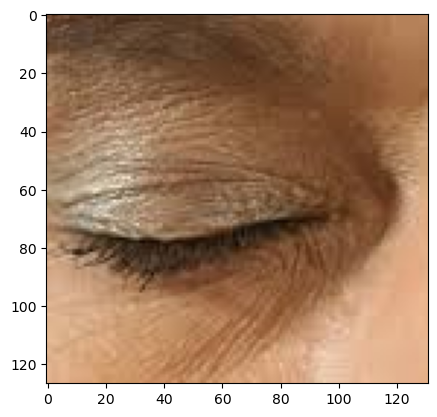

In [192]:
#closeEye
import matplotlib.pyplot as plt
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/Closed/_10.jpg"))

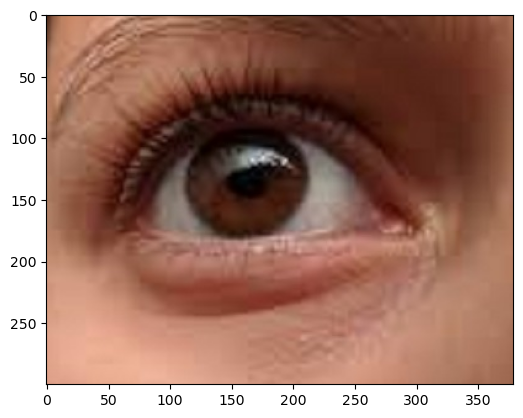

In [193]:
#openEye
import matplotlib.pyplot as plt
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/Open/_100.jpg"))

# image array

In [194]:
a = plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/yawn/10.jpg")

# image shape

In [195]:
a.shape

(480, 640, 3)

# visualize yawn image. 
# Here background is unnecessary. we need only face image array

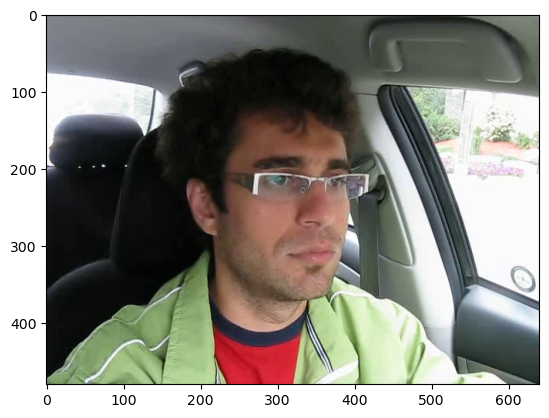

In [196]:
#no yawn
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/no_yawn/1028.jpg"))

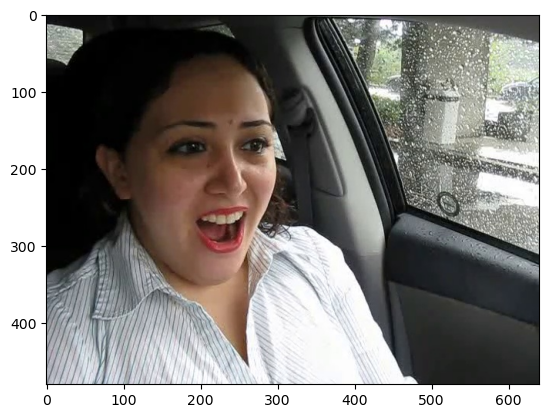

In [197]:
#yawn
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/yawn/104.jpg"))

# for yawn and not_yawn. Take only face

In [198]:
def face_for_yawn(direc="C:/Users/kang mingu/Desktop/etri/model/keras/train", face_cas_path="C:/Users/kang mingu/Desktop/etri/model/keras/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# for closed and open eye

In [199]:
def get_data(dir_path="C:/Users/kang mingu/Desktop/etri/model/keras/train/", face_cas="C:/Users/kang mingu/Desktop/etri/model/keras/haarcascade_frontalface_default.xml", eye_cas="C:/Users/kang mingu/Desktop/etri/model/keras/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [200]:
data_train = get_data()

2
3


# extend data and convert array

In [201]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)

# new variable to store

In [202]:
new_data = append_data()

0
1
2
3


# separate label and features

In [203]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [204]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer

In [205]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [206]:
y = np.array(y)

# train test split

In [207]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [208]:
len(X_test)

578

In [209]:
y_test

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

# Not necessary, only use to matching with my pc version

In [210]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [211]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# tensorflow version

In [212]:
tf.__version__

'2.10.0'

# keras version

In [213]:
import keras
keras.__version__

'2.10.0'

# Data Augmentation

In [214]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [215]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def ResNet(input_shape=(145, 145, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(256, (3, 3), activation="relu")(inputs)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(128, (3, 3), activation="relu")(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(64, (3, 3), activation="relu")(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(32, (3, 3), activation="relu")(x)
    x = MaxPooling2D(2, 2)(x)

    x = resnet_block(x, 32)
    x = resnet_block(x, 32)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# 모델 생성 및 컴파일
model = ResNet()
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 145, 145, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 143, 143, 25  7168        ['input_6[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 71, 71, 256)  0          ['conv2d_54[0][0]']              
 )                                                                                          

In [216]:
history = model.fit(train_generator, epochs=500, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/500
43/43 [==============================] - 6s 110ms/step - loss: 1.1687 - accuracy: 0.4640 - val_loss: 1.4266 - val_accuracy: 0.2336
Epoch 2/500
43/43 [==============================] - 5s 106ms/step - loss: 0.7924 - accuracy: 0.6815 - val_loss: 0.9895 - val_accuracy: 0.5035
Epoch 3/500
43/43 [==============================] - 5s 106ms/step - loss: 0.5531 - accuracy: 0.7869 - val_loss: 0.8333 - val_accuracy: 0.6280
Epoch 4/500
43/43 [==============================] - 5s 105ms/step - loss: 0.4625 - accuracy: 0.7966 - val_loss: 0.5293 - val_accuracy: 0.8356
Epoch 5/500
43/43 [==============================] - 5s 106ms/step - loss: 0.3917 - accuracy: 0.8226 - val_loss: 0.4155 - val_accuracy: 0.7855
Epoch 6/500
43/43 [==============================] - 5s 107ms/step - loss: 0.3484 - accuracy: 0.8567 - val_loss: 0.6499 - val_accuracy: 0.7716
Epoch 7/500
43/43 [==============================] - 5s 105ms/step - loss: 0.3101 - accuracy: 0.8716 - val_loss: 0.9618 - val_accuracy: 0.6194

# history

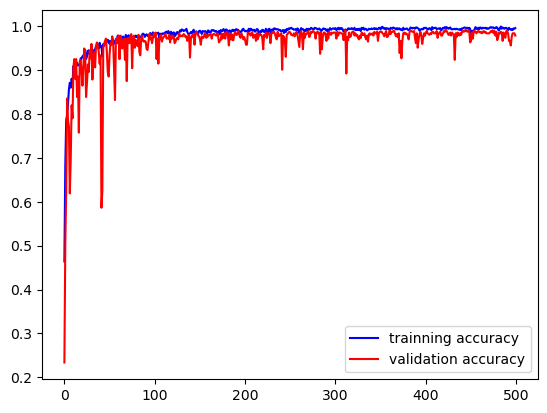

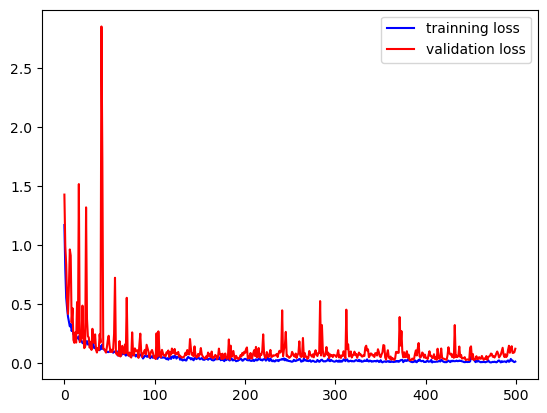

In [217]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [218]:
model.save("C:/Users/kang mingu/Desktop/etri/model/keras/drowiness_new6.h5")

In [219]:
model.save("C:/Users/kang mingu/Desktop/etri/model/keras/drowiness_new6.model")

INFO:tensorflow:Assets written to: C:/Users/kang mingu/Desktop/etri/model/keras/drowiness_new6.model\assets


INFO:tensorflow:Assets written to: C:/Users/kang mingu/Desktop/etri/model/keras/drowiness_new6.model\assets


# Prediction

In [220]:
import numpy as np
from tensorflow.keras.models import load_model

In [221]:
model = load_model('C:/Users/kang mingu/Desktop/etri/model/keras/drowiness_new6.h5')

In [222]:
prediction = model.predict(X_test)

19/19 [==============================] - 0s 18ms/step


In [223]:
prediction=prediction.reshape(-1,1)

In [224]:
prediction.shape

(2312, 1)

In [225]:
type(prediction)

numpy.ndarray

In [226]:
import numpy as np

n_values = int(np.max(prediction) + 1)
prediction_int = prediction.astype(int)
pred=np.eye(n_values)[prediction_int]
pred

array([[[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       ...,

       [[1., 0.]],

       [[0., 1.]],

       [[1., 0.]]])

In [227]:
import tensorflow as tf
import numpy as np

# Replace 'model' with your actual model
prediction_probs = model.predict(X_test)
prediction = np.argmax(prediction_probs, axis=-1)
prediction = prediction.reshape(-1, 1)

n_values = np.max(prediction) + 1
pred = tf.one_hot(prediction, n_values)
pred = tf.reshape(pred, (-1, n_values))

print(y_test.shape)
print(pred.shape)

# If you want to flatten the 'pred' array to have shape (578, 4)
pred = tf.reshape(pred, (578, 4))
print(pred)


19/19 [==============================] - 0s 13ms/step
(578, 4)
(578, 4)
tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(578, 4), dtype=float32)


In [228]:
from sklearn.metrics import confusion_matrix,accuracy_score

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test.argmax(axis=1), pred.numpy().argmax(axis=1))
accuracy = accuracy_score(y_test.argmax(axis=1), pred.numpy().argmax(axis=1))

print(cf_matrix)
print(accuracy)



[[ 61   2   0   0]
 [ 46  26   0   2]
 [  0   0 184  31]
 [  0   0   0 226]]
0.8598615916955017


[Text(0, 0.5, 'yawn'),
 Text(0, 1.5, 'no_yawn'),
 Text(0, 2.5, 'Closed'),
 Text(0, 3.5, 'Open')]

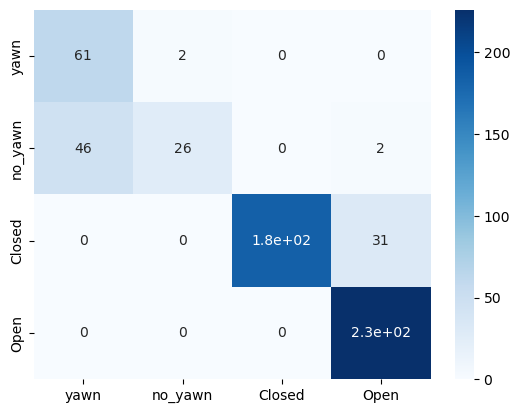

In [229]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(['yawn','no_yawn','Closed','Open'])
ax.yaxis.set_ticklabels(['yawn','no_yawn','Closed','Open'])

# classification report

In [230]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [231]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.57      0.97      0.72        63
     no_yawn       0.93      0.35      0.51        74
      Closed       1.00      0.86      0.92       215
        Open       0.87      1.00      0.93       226

    accuracy                           0.86       578
   macro avg       0.84      0.79      0.77       578
weighted avg       0.89      0.86      0.85       578



# predicting function

In [232]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="C:/Users/kang mingu/Desktop/etri/model/keras/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("C:/Users/kang mingu/Desktop/etri/model/keras/drowiness_new6.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [233]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("C:/Users/kang mingu/Desktop/etri/model/keras/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 156ms/step


1

In [234]:
prediction = model.predict([prepare("C:/Users/kang mingu/Desktop/etri/model/keras/train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 18ms/step


2

In [235]:
prediction = model.predict([prepare("C:/Users/kang mingu/Desktop/etri/model/keras/train/Open/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 17ms/step


3

In [243]:
prediction = model.predict([prepare("C:/Users/kang mingu/Desktop/etri/model/keras/train/yawn/53.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 25ms/step


0

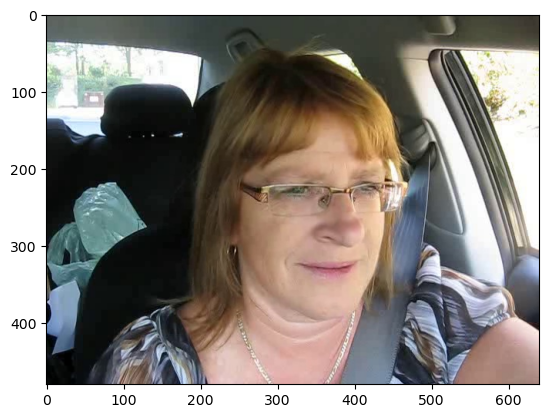

In [237]:
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/no_yawn/1067.jpg"))

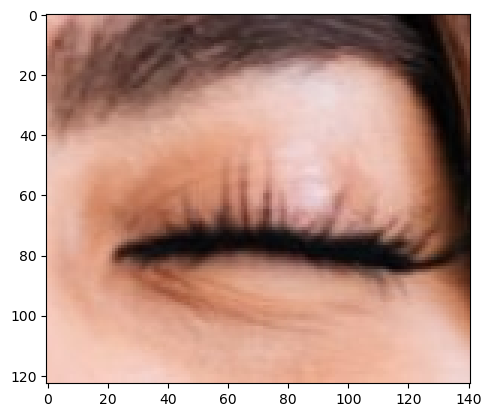

In [238]:
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/Closed/_101.jpg"))

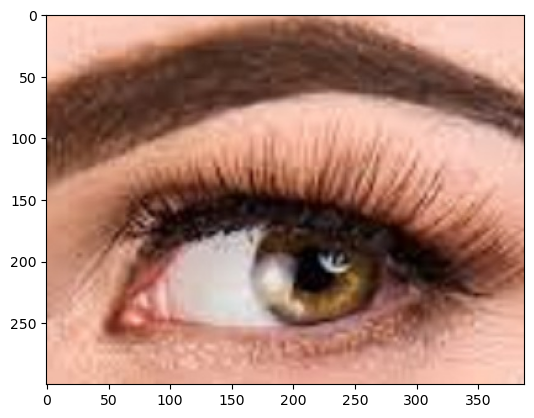

In [239]:
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/Open/_104.jpg"))

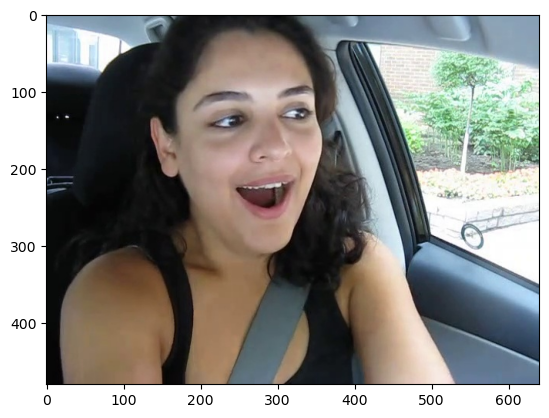

In [244]:
plt.imshow(plt.imread("C:/Users/kang mingu/Desktop/etri/model/keras/train/yawn/53.jpg"))